In [100]:
import aiohttp, http, asyncio, requests, re, time, os, json, pickle
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import steam_tags_f as stf
import functools, random
from dotenv import load_dotenv


In [101]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 16)

In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GETTING THE FIRST DATABASE & SETUP

In [103]:
# Initiate SteamAPP setup
load_dotenv()
token = os.getenv("API_KEY")
params = {"key":token}
url = "http://api.steampowered.com/ISteamApps/GetAppList/v2/"

In [104]:
# grabs a list of all appids.

scode, data = stf.get_url(url, params=params, type = "api")
display(scode)

In [105]:
app_dict = {app['name']: app['appid'] for app in data['applist']['apps']}

In [106]:
## Manually created a dataframe from SteamDB
# # loads the cleaned top 1000 list
top1000 = pd.read_csv('TOP 1000 Games cleaned.csv')

In [107]:
# initiates a new column
top1000["APP ID"] = 0

In [108]:
# merges top1000 with appid list

top1000_2 = stf.add_appid(top1000,app_dict)

# saves a clean version of Top 1000

top1000.to_csv('top_1000_games_cleaned_appid.csv', index=False)

In [109]:
### Manual operation on top_1000_games_cleaned_appid.csv
# manually entered some app-ids that were not fetched, renamed columns, created an id list for the next steps (webscrapping)
appid_fix = pd.read_csv('top_1000_games_cleaned_appid_fix.csv')
txt = appid_fix.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
appid_list = list(txt["id"])

In [110]:
# creates a tag dictionary, saves dict as a pickle object

tag_dict = stf.get_tags(appid_list)
pd.to_pickle(tag_dict, "tag_dict.pkl")

In [111]:
# creates a breakpoint to prevent re-running the get tags

with open ("tag_dict.pkl", "rb") as tag_dict_file:
    tag_dict = pickle.load(tag_dict_file)


In [112]:
# creates a row in our dataframe to accomodate tags.
appid_fix["tags"] = 0

steam_df_tags = stf.add_tags(appid_fix,tag_dict)
pd.to_pickle(steam_df_tags, "steam_df_tags.pkl")

In [113]:
# Opens steam tags pickle and converts into csv

with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)
    
steam_df_tags.to_csv('steam_appid_tags.csv', index=False)

In [114]:
#mp_dict = stf.check_multiplayer(appid_list, token, delay=1)
pd.to_pickle(mp_dict, "mp_dict.pkl")

In [115]:
# Opens multiplayer pickle and converts into csv

with open ("mp_dict.pkl", "rb") as mp_dict_file:
    mp_dict = pickle.load(mp_dict_file)

In [116]:
# adds multiplayer tags into the steam tags
steam_df_tags_mp = stf.add_mp(steam_df_tags, mp_dict)

steam_df_tags_mp.to_csv('steam_appid_tags_mp.csv', index=False)

In [117]:
# creates a dictionary with ids as keys, tags as values. Saves as pickle

tags_mp_dict = steam_df_tags_mp.set_index("Steam App ID")["tags"].to_dict()

with open ("tags_mp_dict.pkl", "wb") as tags_mp_dict_file:
    pickle.dump(tags_mp_dict, tags_mp_dict_file)

In [118]:
# makes a dict with appids and game titles

tags_name_dict = steam_df_tags_mp.set_index("Steam App ID")["Game Title"].to_dict()

In [119]:
# converts keys into str (from int)

tags_mp_dict_str = {str(key):value for key, value in tags_mp_dict.items()}


FUNCTIONS

MAIN CODES

In [120]:
## webscrapping, output

game_id_dict, error_list = stf.overall_fetch(appid_list)

In [121]:
# Saves our main source of information into a feather
output = pd.DataFrame.from_dict(game_id_dict)
output.to_feather("output.feather")

In [122]:
# Saves our error results into an error csv
err_table = pd.DataFrame(error_list)
err_table.to_csv("error.csv")

In [123]:
### Bridges the webscrapping/API part with the cleaning and processing parts

# imports our feather database & gives us an idea of the shape/NaN's present
output = pd.read_feather("output.feather")
#display(output.isna().sum())
#display(output.shape)

In [124]:
# Cleans database of most recent games (so from Aug 2019 -> Present)
out2 = output.copy() 
filtered = out2.isna().sum(axis=0) > 85 ## 85 = Aug 2019
filter = filtered[filtered]

mask = list(filter.index)
for code in mask:
    out2.drop(code, axis = 1, inplace=True)

In [125]:
### New row 0 
out3 = out2.copy()

# Define a new row of zeroes with the same number of columns as df
zero_row = pd.DataFrame([[0] * len(out3.columns)], columns=out3.columns)

# Concatenate the new zero row at index 0
out4 = pd.concat([zero_row, out3]).reset_index(drop=True)

# imports the tags and the multiplayer tags dictionaries
with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)

with open ("mp_dict.pkl", "rb") as mp_dict_file:
    mp_dict = pickle.load(mp_dict_file)

# joins dictionaries
steam_df_tags_mp = stf.add_mp(steam_df_tags, mp_dict)

# creates the tags row and appends to out4
tags_mp_dict = steam_df_tags_mp.set_index("Steam App ID")["tags"].to_dict()
tags_mp_dict_str = {str(key):value for key, value in tags_mp_dict.items()}
out4_2 = stf.add_tags_df(out4, tags_mp_dict_str)

#display(out4_2)

In [126]:
# Converts "Date" into DataFrame index
out5=out4_2.copy()

# creates a "Date" column
out5_extracted = out5["730"][1:].map(lambda x: x["Date"] if isinstance(x, dict) else x)

# takes appid "730" (which is one of the completed ones and uses it to define "Data" column)
out5["Date"] = out5_extracted # Adds the dates into column "Date"
out5["Date"][0] = "Tags" # Adds the Tags into row 0
out5.set_index("Date", inplace=True) # Sets column "Date" to be the index

#display(out5)

In [127]:
##### Converts columns into game's name
out6 = out5.copy()

# creates the id list
txt2 = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
txt2 = txt2[["id","title"]]
txt2.set_index("id", inplace=True)

# Create a mapping from ids to titles
title_mapping = {str(k): v for k, v in txt2["title"].to_dict().items()}

# Rename the columns in out4 using the mapping
out6.columns = [title_mapping.get(str(col), col) for col in out4.columns]

# Creates our main dataframe visualization 
visual = "Peak Players" # DB issue, needs fixing
out6 = out6.apply(lambda x: x.apply(lambda y: y.get(visual) if isinstance(y, dict) and visual in y else y), axis=0)
out6[1:] = round(out6[1:].fillna(0).astype(float),0).astype(int)

#display(out6)

In [128]:
# More cleaning while looking at data. Disregarding outliers etc..
out7 = out6.copy()

## Drops bot-afflicted games that warped data == Outlier
out7.drop("POSTAL", axis=1, inplace=True)

# Creates a new column (Total) and concats into the existing dataframe
out7["Total"]=0
out7.loc[out7.index[1:], 'Total'] = out7.iloc[1:, :].sum(axis=1)

#display(out7)

In [129]:
# Adds Z-Column
out8 = out7.copy()

out8['Z'] = 0 # creates an empty column named "Z"
out8['Z'][1:] = stf.z_norm(out8['Total'][1:]) # adds Z-normalized values into Z column

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_17596\6564845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out8['Z'][1:] = stf.z_norm(out8['Total'][1:]) # adds Z-normalized values into Z column


## DATA VISUALIZATION ##

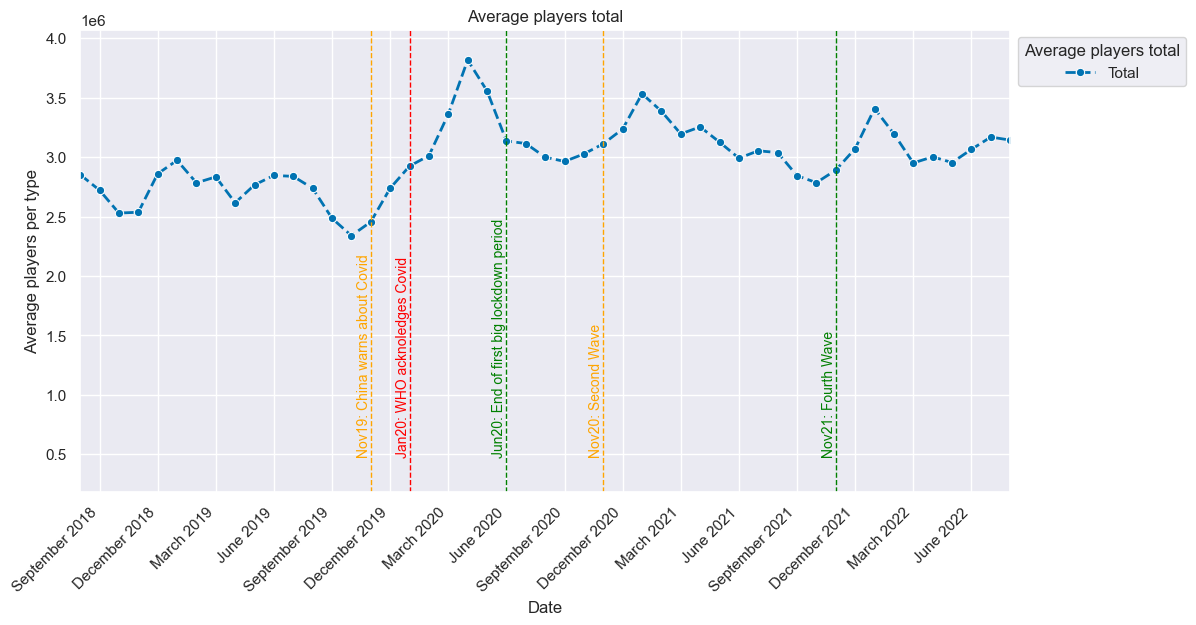

In [130]:
# plots total average players per date

stf.t_plot(out8,["Total"],"Average players total","y")

In [131]:
list_tags =[value.split(",") for value in tags_mp_dict.values()]
set_tags = {item.strip() for sublist in list_tags for item in sublist}

#list(set_tags)

In [132]:
# creates the dataframes for all the game_types defined
game_types = ['Racing', 'Sports', 'RPG', 'Action', 'Casual', 'Adventure', 'Indie', 'Simulation', 'Strategy', 'Multi-player', 'Co-op']

# creates a dictionary with all the dataframes created
lgames = {}

for game in game_types:
    globals()[f"{game}_df"] = stf.make_type(out8, game)
    lgames[f"{game}_df"] = globals()[f"{game}_df"]
    

c:\Users\Utilizador\Desktop\IRONHACK\Project 3\Project-3\steam_tags_f.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[substring]=0
c:\Users\Utilizador\Desktop\IRONHACK\Project 3\Project-3\steam_tags_f.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[substring]=0
c:\Users\Utilizador\Desktop\IRONHACK\Project 3\Project-3\steam_tags_f.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [133]:
# compresses all the common types: ['Racing', 'Sports']
sports_df = pd.concat([Racing_df, Sports_df], axis=1)
sports_df["sports"]=sports_df.sum(axis=1)
sports_df.drop(['Sports','Racing'], axis=1, inplace = True)
sports_df.rename(columns={"sports": "Sports"}, inplace=True)

lgames["sports_df"]=sports_df

In [134]:
# creates a dataframe of a specific genre with a single column that contains the specified value 
df2 = out8.copy()

columns_to_keep = df2.columns[~df2.iloc[0].astype(str).str.strip().str.contains("Multi-player")]
output = out8[columns_to_keep].copy()

# Step 2: Ensure all relevant columns are numeric
for col in output.columns:
    output[col] = pd.to_numeric(output[col], errors='coerce')

# Step 3: Add "not multi-player" column by summing numeric values, ignoring the first row
output["not Multi-player"] = output.iloc[1:, :].sum(axis=1)  # Sum from the second row onward

# Step 4: Subtract the "Total" for each relevant row
output["not Multi-player"] = output["not Multi-player"] - pd.to_numeric(out8.iloc[1:, out8.columns.get_loc("Total")], errors='coerce')

# Step 5: Ensure values do not exceed the total (if needed)
output["not Multi-player"] = output["not Multi-player"].clip(lower=0)  # Avoid negative values

# Step 6: Filter the resulting DataFrame for "not multi-player"
not_mp_df = output.filter(like="not Multi-player", axis=1)

#not_mp_df

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_17596\2359203602.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output["not Multi-player"] = output.iloc[1:, :].sum(axis=1)  # Sum from the second row onward


In [135]:
# removes old dataframes from the list 

pop_keys = ['Racing_df', 'Sports_df']

for key in pop_keys:
    lgames.pop(key, None)

# makes a single dataframe with the total average per gametype
lgames_upd=None

for df in lgames.values():
    if lgames_upd is None:
        lgames_upd = df
    else:
        lgames_upd = pd.merge(lgames_upd, df, left_index=True, right_index=True)

lgames_upd["not Multi-player"] = not_mp_df
lgames_upd["Total"] = out7["Total"]
#display(lgames_upd)

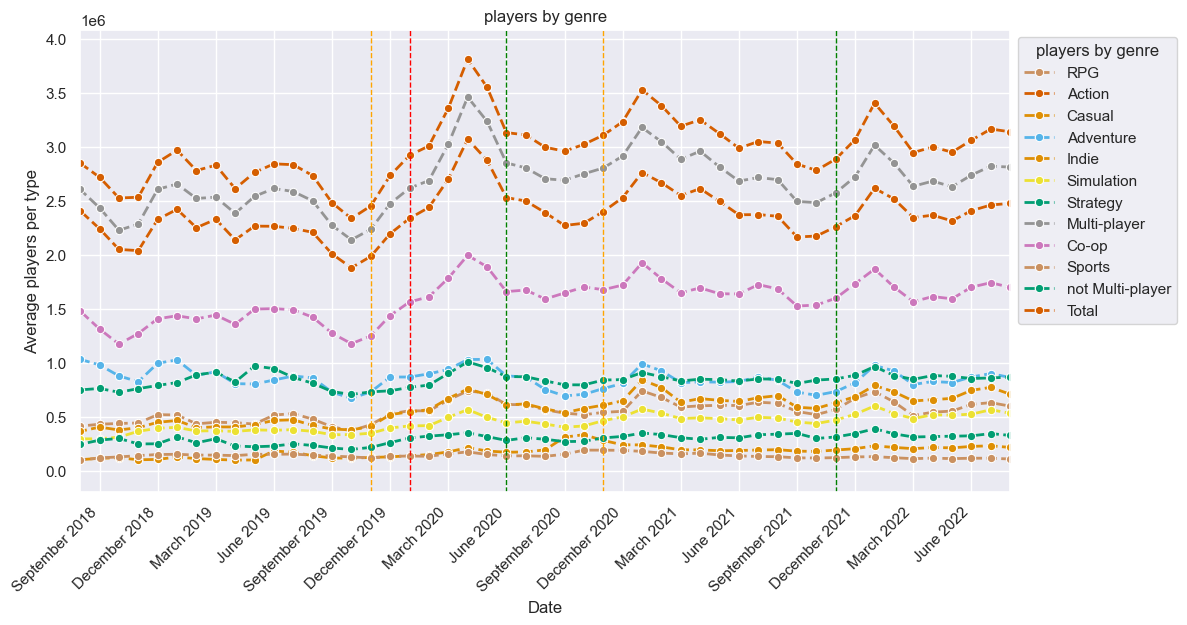

In [136]:
# plots average player by gender over time

stf.t_plot(lgames_upd,list(lgames_upd.columns),"players by genre","n")

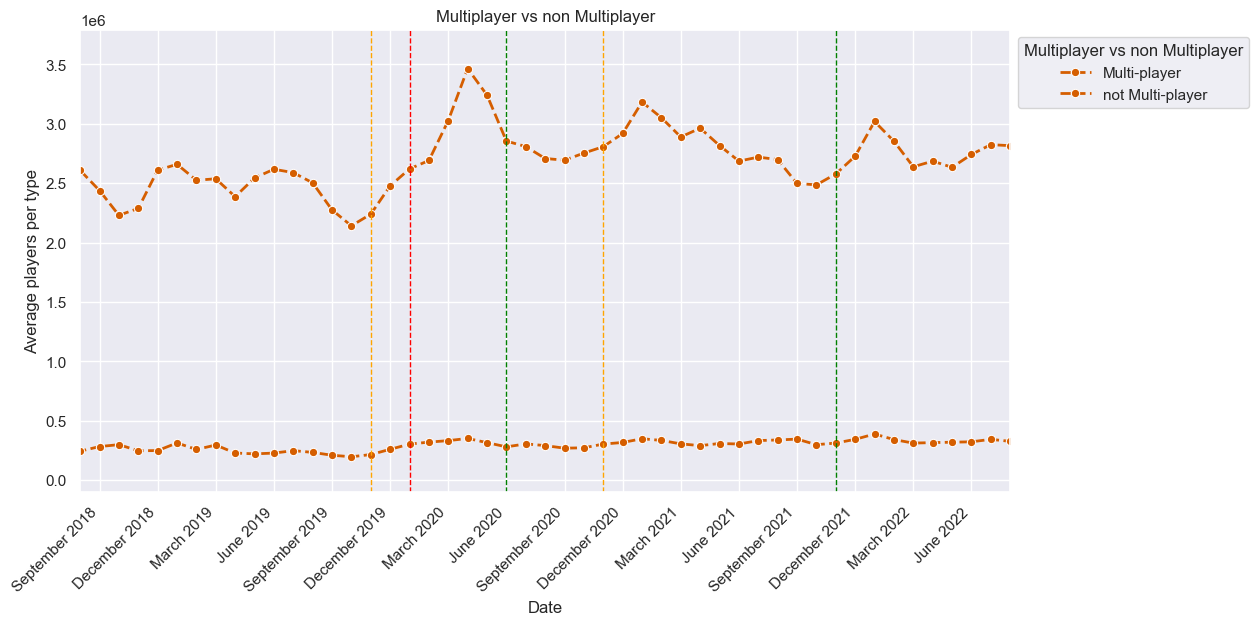

In [137]:
# plots multiplayer vs non-multiplayer over time

stf.t_plot(lgames_upd,["Multi-player", "not Multi-player"],"Multiplayer vs non Multiplayer","n")